In [65]:
import galois
import itertools
import stim 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
from statsmodels.stats.proportion import proportion_confint
from datetime import datetime

plt.style.use("seaborn-v0_8-darkgrid") # Set plot style for all matplotlib figures
np.set_printoptions(threshold=sys.maxsize) # Print full numpy arrays without truncation

# Define Galois field GF(2) for binary operations
GF = galois.GF(2)

# Define qubits, data qubits, flag qubits, and cube qubits
qubits = [*range(17)]
data = [*range(15)]
flag = [15, 16]
cube = [*range(8)]

# Define single- and two-qubit error types
one_qubit = ["X_ERROR(1)", "Y_ERROR(1)", "Z_ERROR(1)"]
two_qubit = [[a, b] for a in one_qubit for b in one_qubit]

# Parity check matrices for the codes
H2 = np.array([
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
], dtype=int)
H2 = GF(H2)

H = np.array([
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
], dtype=int)
H = GF(H)


In [ ]:
# Function to compute the syndrome for a given support vector of X-error and H_z matrix
def syndrome(x, H):
    """
    Compute the syndrome for a given support vector of X-error x and H_z matrix H.
    Args:
        x (array-like): Support vector of X-error.
        H (np.ndarray): H_z matrix.
    Returns:
        np.ndarray: Syndrome vector.
    """
    x = GF(x, dtype=int).reshape(-1, 1)
    return np.matmul(H, x)

# Build lookup tables for syndrome decoding
def build_syndrome_tables(H):
    """
    Build syndrome and reverse lookup tables for a given H_z matrix H.
    Args:
        H (np.ndarray): H_z matrix.
    Returns:
        syndromes (dict): Maps support vectors of X-error to syndromes.
        syndromesreverse (dict): Maps syndromes to parity of X-error.
    """
    n = H.shape[1]
    syndromes = {tuple(np.zeros(n, dtype=int)): tuple(np.zeros(H.shape[0], dtype=int))}
    syndromesreverse = {tuple(np.zeros(H.shape[0], dtype=int)): 0}
    for num_ones in range(1, n):
        for indices in itertools.combinations(range(n), num_ones):
            x = np.zeros(n, dtype=int)
            for index in indices:
                x[index] = 1
            s = syndrome(x, H)
            s_tuple = tuple(int(bit) for bit in s.flatten())
            if s_tuple not in syndromes.values():
                syndromes[tuple(x)] = s_tuple
                syndromesreverse[s_tuple] = sum(x) % 2
    return syndromes, syndromesreverse

# Build syndrome lookup tables for both codes (using support vectors of X-error and H_z matrices)
syndromes, syndromesreverse = build_syndrome_tables(H)
syndromes2, syndromesreverse2 = build_syndrome_tables(H2)

# Decode syndromes using the lookup table
def decoder(events, syndromesreverse):
    """
    Decode syndromes using a lookup table.
    Args:
        events (np.ndarray): Array of syndromes (detector outcomes).
        syndromesreverse (dict): Lookup table for decoding.
    Returns:
        np.ndarray: Array of predicted logical values.
    """
    predictions = np.zeros((events.shape[0], 1))
    for i in range(events.shape[0]):
        predictions[i, :] = syndromesreverse[tuple(events[i, :])]
    return predictions

# Functions to initialize circuits for different verification protocols

# Returns the clean Munich toolkit verification circuit with 2 ancilla qubits
def clean_munich_toolkit_circuit():
    circuit = stim.Circuit('''
        R 0 1 3 4 6 7 8 9 11 13 14 15 16
        RX 2 5 10 12''')
    circuit.append("TICK")
    circuit.append("CX", [0, 13, 2, 8, 12, 4, 10, 3, 5, 1]) 
    circuit.append("TICK")
    circuit.append("CX", [8, 14, 10, 13, 3, 9, 4, 11, 12, 6, 5, 0])
    circuit.append("TICK")
    circuit.append("CX", [1, 3, 4, 7, 9, 11, 12, 13, 5, 6, 8, 10, 14, 0]) 
    circuit.append("TICK") 
    circuit.append("CX", [3, 2, 1, 7, 8, 11, 12, 14, 0, 4, 10, 6, 13, 5])
    circuit.append("TICK") 
    circuit.append("CX", [3, 15, 1, 16])
    circuit.append("TICK")
    circuit.append("CX", [4, 15, 6, 16])
    circuit.append("TICK")
    circuit.append("CX", [8, 15, 9, 16])
    circuit.append("TICK")
    circuit.append("CX", [13, 15, 14, 16])
    circuit.append("MZ", flag)
    circuit.append("TICK")
    circuit.append("MZ", data)
    circuit.append("DETECTOR", [stim.target_rec(-15), stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-11), stim.target_rec(-10)])
    circuit.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-9)])
    circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-11), stim.target_rec(-7), stim.target_rec(-3)])
    
    circuit.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-10), stim.target_rec(-6), stim.target_rec(-4)])
    
    circuit.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-6), stim.target_rec(-5)])
    
    circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-4), stim.target_rec(-3)])
    
    circuit.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-4), stim.target_rec(-2)])
    circuit.append("DETECTOR", [stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-2), stim.target_rec(-1)])
    # Include each data qubit measurement in the logical Z measurement, which is Z_all
    for j in range(1, 16):
        circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-j), 0)
    circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-16), 1)
    circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-17), 2)
    circuit.append("TICK")
    return circuit

# Returns the clean intermediate verification circuit with 2 ancilla qubits
def clean_intermediate_verification_circuit():
    clean_circuit = stim.Circuit('''
        R 0 1 2 3 4 5 6 8 9 10 12 15 16
        RX 7 11 13 14''')
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 6, 13, 12, 11, 10]) 
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 5, 14, 12, 11, 9, 10, 8])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 4, 14, 10, 13, 9, 12, 8, 11, 16]) 
    clean_circuit.append("TICK") 
    clean_circuit.append("CX", [7, 3, 9, 15, 8, 16])
    clean_circuit.append("TICK") 
    clean_circuit.append("CX", [7, 2, 10, 15, 14, 16])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 1, 12, 15, 13, 16])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 0])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [8, 0, 9, 1, 10, 2, 11, 3, 12, 4, 13, 5, 14, 6])
    clean_circuit.append("MZ", flag)
    clean_circuit.append("TICK")
    clean_circuit.append("MZ", data)
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-12)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-15), stim.target_rec(-11), stim.target_rec(-10)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-13) , stim.target_rec(-15), stim.target_rec(-11), stim.target_rec(-9)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-8)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-15), stim.target_rec(-6), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-13) , stim.target_rec(-15), stim.target_rec(-5), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-11) , stim.target_rec(-15), stim.target_rec(-3), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-4) , stim.target_rec(-5), stim.target_rec(-6), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-2) , stim.target_rec(-3), stim.target_rec(-6), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-1) , stim.target_rec(-3), stim.target_rec(-5), stim.target_rec(-7)])
    # Include each data qubit measurement in the logical Z measurement, which is Z_all
    for j in range(1, 16):
        clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-j), 0)
    clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-16), 1)
    clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-17), 2)
    clean_circuit.append("TICK")
    return clean_circuit


# Returns the clean Peham circuit (the verification circuit from Peham et al. 2024)
def clean_peham_circuit():
    flag = [15]
    clean_circuit = stim.Circuit('''
        R 1 2 3 4 5 6 7 9 11 12 13 15
        RX 0 8 10 14''')
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [14, 7, 10, 3, 8, 1]) 
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [0, 1, 3, 2, 7, 5, 10, 9, 14, 12])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [0, 3, 1, 2, 5, 4, 7, 6, 8, 9, 12, 11, 14, 13]) 
    clean_circuit.append("TICK") 
    clean_circuit.append("CX", [0, 7, 1, 4, 2, 5, 3, 6, 8, 12, 9, 11, 10, 13])
    clean_circuit.append("TICK") 
    clean_circuit.append("CX", [0, 15])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [5, 15])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [11, 15])
    clean_circuit.append("MZ", flag)
    clean_circuit.append("TICK")
    clean_circuit.append("MZ", data)
    clean_circuit.append("DETECTOR", [stim.target_rec(-15), stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-11), stim.target_rec(-10)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-9)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-11), stim.target_rec(-7), stim.target_rec(-3)])
    
    clean_circuit.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-10), stim.target_rec(-6), stim.target_rec(-4)])
    
    clean_circuit.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-6), stim.target_rec(-5)])
    
    clean_circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-4), stim.target_rec(-3)])
    
    clean_circuit.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-4), stim.target_rec(-2)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-2), stim.target_rec(-1)])
    # Include each data qubit measurement in the logical Z measurement, which is Z_all
    for j in range(1, 16):
        clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-j), 0)
    clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-16), 1)
    clean_circuit.append("TICK")
    return clean_circuit

# Returns the clean intermediate verification circuit with one ancilla qubit
def clean_intermediate_verification_circuit_one_ancilla():
    flag = [15]
    clean_circuit = stim.Circuit('''
        R 0 1 2 3 4 5 6 8 9 10 12 15
        RX 7 11 13 14''')
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 6, 11, 9, 13, 12, 14, 10]) 
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 5, 13, 8, 11, 10, 14, 12])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 4, 13, 9, 10, 8, 12, 15]) 
    clean_circuit.append("TICK") 
    clean_circuit.append("CX", [7, 3, 9, 15])
    clean_circuit.append("TICK") 
    clean_circuit.append("CX", [7, 2, 10, 15])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 1])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [7, 0])
    clean_circuit.append("TICK")
    clean_circuit.append("CX", [8, 0, 9, 1, 10, 2, 11, 3, 12, 4, 13, 5, 14, 6])
    clean_circuit.append("MZ", flag)
    clean_circuit.append("TICK")
    clean_circuit.append("MZ", data)
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-12)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-15), stim.target_rec(-11), stim.target_rec(-10)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-13) , stim.target_rec(-15), stim.target_rec(-11), stim.target_rec(-9)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-8)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-14) , stim.target_rec(-15), stim.target_rec(-6), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-13) , stim.target_rec(-15), stim.target_rec(-5), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-11) , stim.target_rec(-15), stim.target_rec(-3), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-4) , stim.target_rec(-5), stim.target_rec(-6), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-2) , stim.target_rec(-3), stim.target_rec(-6), stim.target_rec(-7)])
    clean_circuit.append("DETECTOR", [stim.target_rec(-1) , stim.target_rec(-3), stim.target_rec(-5), stim.target_rec(-7)])
    # Include each data qubit measurement in the logical Z measurement, which is Z_all
    for j in range(1, 16):
        clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-j), 0)
    clean_circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-16), 1)
    clean_circuit.append("TICK")
    return clean_circuit

# Functions for noise addition, sampling, decoding, logical error checking, simulation, errorbar computation and plotting

# Create a noisy version of a clean circuit by adding circuit level noise
def make_noisy_circuit(clean_circuit_func, p):
    """
    Creates a noisy version of a clean circuit by adding noise after each gate.
    """
    clean_circuit = clean_circuit_func()
    noisy_circuit = stim.Circuit()
    all_qubits = set()
    obs_include_count = 0  # counter for observable indices

    # Collect all qubits used in the circuit
    for instruction in clean_circuit:
        for q in instruction.targets_copy():
            if hasattr(q, "value") and isinstance(q.value, int) and q.value >= 0:
                all_qubits.add(q.value)

    for instruction in clean_circuit:
        name = instruction.name
        targets = [q.value for q in instruction.targets_copy() if hasattr(q, "value") and isinstance(q.value, int) and q.value >= 0]
        # Special case for OBSERVABLE_INCLUDE
        if name == "OBSERVABLE_INCLUDE":
            if obs_include_count < 15:
                idx = 0
            elif obs_include_count == 15:
                idx = 1
            else:
                idx = 2
            noisy_circuit.append(name, instruction.targets_copy(), idx)
            obs_include_count += 1
        elif name == "M":
            # Add X_ERROR BEFORE the measurement
            if targets:
                noisy_circuit.append("X_ERROR", targets, p)
            noisy_circuit.append(name, instruction.targets_copy())
        else:
            noisy_circuit.append(name, instruction.targets_copy())
            # Add noise after certain gates (use targets as-is)
            if name == "R":
                noisy_circuit.append("X_ERROR", instruction.targets_copy(), p)
            elif name == "RX":
                noisy_circuit.append("Z_ERROR", instruction.targets_copy(), p)
            elif name == "CX":
                noisy_circuit.append("DEPOLARIZE2", instruction.targets_copy(), p)
                idling = [q for q in all_qubits if q not in targets]
                if idling:
                    noisy_circuit.append("DEPOLARIZE1", idling, p)
    return noisy_circuit

# Simulate a circuit with noise and return detector and observable outcomes
def sample(circuit_func, p, N_runs, seed):
    """
    Simulate a circuit with noise and return detector and observable outcomes.

    Args:
        circuit_func (callable): Function that returns a clean stim.Circuit.
        p (float): Physical error probability for the circuit.
        N_runs (int): Number of simulation shots.
        seed (int): Random seed for reproducibility.

    Returns:
        defects (np.ndarray): Array of detector outcomes (syndromes).
        observable (np.ndarray): Array of logical observable outcomes.
    """
    circuit = make_noisy_circuit(circuit_func, p)
    sampler = circuit.compile_detector_sampler(seed=seed)
    defects, observable = sampler.sample(shots=N_runs, separate_observables=True)
    return defects, observable

# Extract the gate locations from a clean circuit function, for fault-tolerance testing
def get_gate_locations_from_func(clean_circuit_func):
    """
    Extract the gate_loc dictionary from a function that returns a clean circuit.

    Args:
        clean_circuit_func (callable): Function that returns a stim.Circuit.

    Returns:
        dict: Dictionary mapping each layer to the qubit indices (as integers) of the CX gates.
    """
    clean_circuit = clean_circuit_func()
    gate_loc = {}
    layer = 1
    for instruction in clean_circuit:
        if instruction.name == "CX":
            gate_loc[layer] = [q.value for q in instruction.targets_copy()]
            layer += 1
    return gate_loc

# Check whether single faults lead to logical errors in the circuit
def check_logical_errors(clean_circuit_func, syndromes, syndromesreverse):
    """
    Test all single- and two-qubit errors at all possible locations in the circuit.
    Prints 'logical error!' if a logical error occurs, otherwise prints 'Circuit fault-tolerant'.
    """
    found_error = False

    print("Checking single-qubit errors")
    # Single-qubit errors
    for i in tqdm(range(9)):
        for j in range(3):
            for k in range(17):
                circuit = clean_circuit_func()
                # Insert a single-qubit error at the correct location
                circuit.insert((i+1)*2, stim.Circuit(one_qubit[j] + " " + str(k)))
                sampler = circuit.compile_detector_sampler(seed=404)
                detection_events, observables = sampler.sample(shots=1, separate_observables=True)
                predictions = decoder(detection_events, syndromesreverse)
                actual = observables[0, 0]
                predicted = predictions
                # Only check if the run is accepted
                if observables.shape[1] > 2:
                    accepted = observables[0, 1] * observables[0, 2] != 1
                else:
                    accepted = observables[0, 1] != 1

                if accepted:
                    if not float(actual) == predicted:
                        print("logical error!")
                        print(f"Error at layer {i+1}, qubit {k}, error type {one_qubit[j]}")
                        print(f"Actual: {actual}, Predicted: {predicted}")
                        print(f"Detection events: {detection_events}")
                        print(f"Observables: {observables}")
                        s_tuple = tuple(int(bit) for bit in detection_events.flatten())
                        assumed_error = [key for key, value in syndromes.items() if value == s_tuple]
                        print(f"Assumed error: {assumed_error}")
                        found_error = True
                        break
            if found_error:
                break
        if found_error:
            break
    print("Checking two-qubit errors on qubits acted on by two-qubit gates")
    # Two-qubit errors
    gate_loc = get_gate_locations_from_func(clean_circuit_func)
    for i in tqdm(range(len(gate_loc.keys()))):
        qubits = gate_loc[i+1]
        for j in range(9):
            errors = two_qubit[j]
            for k in range(int(len(qubits)/2)):
                qubit1 = qubits[k*2]
                qubit2 = qubits[k*2+1]
                circuit = clean_circuit_func()
                # Insert two single-qubit errors at the correct location
                circuit.insert((i+2)*2, stim.Circuit(errors[0] + " " + str(qubit1)))
                circuit.insert((i+2)*2, stim.Circuit(errors[1] + " " + str(qubit2)))
                sampler = circuit.compile_detector_sampler(seed=404)
                detection_events, observables = sampler.sample(shots=1, separate_observables=True)
                predictions = decoder(detection_events, syndromesreverse)
                actual = observables[0, 0]
                predicted = predictions
                # Only check if the run is accepted
                if observables.shape[1] > 2:
                    accepted = observables[0, 1] * observables[0, 2] != 1
                else:
                    accepted = observables[0, 1] != 1

                if accepted:
                    if not float(actual) == predicted:
                        print("logical error!")
                        print(f"Error at layer {i+1}, qubit {k}, error type {two_qubit[j]}")
                        print(f"Actual: {actual}, Predicted: {predicted}")
                        print(f"Detection events: {detection_events}")
                        print(f"Observables: {observables}")
                        s_tuple = tuple(int(bit) for bit in detection_events.flatten())
                        assumed_error = [key for key, value in syndromes.items() if value == s_tuple]
                        print(f"Assumed error: {assumed_error}")
                        found_error = True
                        break
            if found_error:
                break
        if found_error:    
            break
    if not found_error:
        print("Circuit fault-tolerant")

# Function to run a logical error simulation for a range of physical error probabilities
def run_logical_error_simulation(N_runs, p_values, func_circ, syndromesreverse):
    """
    Simulate logical error rates and acceptance rates for a range of physical error probabilities.

    Args:
        N_runs (int): Number of accepted runs which is used to calculate logical error probability.
        p_values (array-like): List or array of physical error probabilities.
        func_circ (callable): Function that returns a clean stim.Circuit.
        syndromesreverse (dict): Lookup table for decoding.

    Returns:
        p_log (np.ndarray): Number of logical errors for each p (out of accepted runs in N_runs shots).
        p_acc (np.ndarray): Number of accepted runs in the first N_runs shots for each p (≤ N_runs).
            (An "accepted run" is a shot where observables[shot,1]*observables[shot,2] != 1.)
    """
    N = len(p_values)
    p_log = np.zeros(N)
    p_acc = np.zeros(N)

    for j in tqdm(range(N)):
        p = p_values[j]
        acceptance = 0
        num_errors = 0
        detection_events, observables = sample(func_circ, p, N_runs, seed=j)
        predictions = decoder(detection_events, syndromesreverse)
        for shot in range(N_runs):
            actual_for_shot = observables[shot, 0]
            predicted_for_shot = predictions[shot]
            if observables.shape[1] > 2:
                accepted = (observables[shot, 1] * observables[shot, 2] != 1)
            else:
                accepted = (observables[shot, 1] != 1)
            if accepted:
                acceptance += 1
                if not np.array_equal([float(actual_for_shot)], predicted_for_shot):
                    num_errors += 1
        p_acc[j] = acceptance
        p_log[j] = num_errors
    return p_log, p_acc

# Function to compute Wilson confidence intervals and error bars for binomial data
def compute_errorbars(successes, N_runs, alpha=0.32, method="wilson"):
    """
    Compute Wilson confidence intervals and error bars for binomial data.

    Args:
        successes (np.ndarray): Array of counts (e.g. p_log or p_acc).
        N_runs (int): Number of trials per point.
        alpha (float): Confidence level.
        method (str): Method for confidence interval.

    Returns:
        conf (np.ndarray): Confidence interval (2,N).
        errorbars (np.ndarray): Error bars (2,N).
        norm_p (np.ndarray): Normalized probability (successes/N_runs).
    """
    from statsmodels.stats.proportion import proportion_confint
    conf = proportion_confint(successes, N_runs*np.ones_like(successes), alpha=alpha, method=method)
    norm_p = successes / N_runs
    subtr = np.array([norm_p, norm_p])
    errorbars = np.abs(conf - subtr)
    return conf, errorbars

# Function to plot multiple datasets with error bars
def plot_multiple_errorbars(x, y_list, yerr_list, labels, xlabel, ylabel, title, filename, legend_loc="upper left", loglog=True):
    """
    Plot multiple datasets with error bars on the same figure.

    Args:
        x (array-like): X-axis values (shared for all datasets).
        y_list (list of array-like): List of Y-axis datasets to plot.
        yerr_list (list of array-like): List of error bars corresponding to each dataset in y_list.
        labels (list of str): List of labels for each dataset (for the legend).
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis.
        title (str): Title of the plot.
        filename (str): Filename to save the figure.
        legend_loc (str, optional): Location of the legend (default "upper left").
        loglog (bool, optional): If True, use log-log scale (default True).
    """
    for y, yerr, label in zip(y_list, yerr_list, labels):
        plt.errorbar(x, y, yerr=yerr, label=label)
    if loglog:
        plt.yscale('log')
        plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.savefig(filename)
    plt.show()


In [106]:
# Check fault-tolerance of the clean circuits using all single- and two-qubit errors (single faults)
check_logical_errors(clean_intermediate_verification_circuit, syndromes2, syndromesreverse2)
check_logical_errors(clean_munich_toolkit_circuit, syndromes, syndromesreverse)
check_logical_errors(clean_peham_circuit, syndromes, syndromesreverse)
check_logical_errors(clean_intermediate_verification_circuit_one_ancilla, syndromes2, syndromesreverse2)

# Insert multiple X-errors that should cause a logical error in the intermediate verification circuit
print("Inserting errors in the intermediate verification circuit that should lead to a logical error")
circuit = clean_intermediate_verification_circuit()
circuit.insert((7+2)*2, stim.Circuit(one_qubit[0]+" "+str(0))) 
circuit.insert((7+2)*2, stim.Circuit(one_qubit[0]+" "+str(1))) 
circuit.insert((7+2)*2, stim.Circuit(one_qubit[0]+" "+str(2))) 
circuit.insert((7+2)*2, stim.Circuit(one_qubit[0]+" "+str(3))) 
sampler = circuit.compile_detector_sampler(seed = 404)
detection_events, observables = sampler.sample(shots=1, separate_observables=True) 
predictions = decoder(detection_events, syndromesreverse2)
actual = observables[0,0]
predicted = predictions

# Only check if the run is accepted (not rejected by flags)
if observables[0,1]*observables[0,2] != 1:
    if not float(actual) == predicted: # Compare correction and actual measured observable
        print("logical error!")
print(observables)

# Insert errors that should cause the state to be rejected in the intermediate verification circuit
print("Inserting errors in the intermediate verification circuit that should lead to the state being rejected")
circuit = clean_intermediate_verification_circuit()
circuit.insert((1)*2, stim.Circuit(one_qubit[0]+" "+str(10))) 
sampler = circuit.compile_detector_sampler(seed = 404)
detection_events, observables = sampler.sample(shots=1, separate_observables=True) 
predictions = decoder(detection_events, syndromesreverse2)
actual = observables[0,0]
predicted = predictions

# Only check if the run is accepted (not rejected by flags)
if observables[0,1]*observables[0,2] != 1:
    if not float(actual) == predicted: # Compare correction and actual measured observable
        print("logical error!")
else:
    print("not accepted")
print(observables)



Checking single-qubit errors


100%|██████████| 9/9 [00:01<00:00,  8.53it/s]


Checking two-qubit errors on qubits acted on by two-qubit gates


100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


Circuit fault-tolerant
Checking single-qubit errors


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


Checking two-qubit errors on qubits acted on by two-qubit gates


100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


Circuit fault-tolerant
Checking single-qubit errors


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


Checking two-qubit errors on qubits acted on by two-qubit gates


100%|██████████| 7/7 [00:00<00:00, 17.36it/s]


Circuit fault-tolerant
Checking single-qubit errors


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


Checking two-qubit errors on qubits acted on by two-qubit gates


100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

Circuit fault-tolerant
Inserting errors in the intermediate verification circuit that should lead to a logical error
logical error!
[[False False False]]
Inserting errors in the intermediate verification circuit that should lead to the state being rejected
not accepted
[[False  True  True]]


In [107]:

# Set parameters for the simulation
N_runs = 10**6
N = 20
p_values = np.logspace(-5, -1, N)

# Run logical error and acceptance rate simulation for both circuits
p_log, p_acc = run_logical_error_simulation(
    N_runs, p_values, clean_munich_toolkit_circuit, syndromesreverse
)
p_log_2, p_acc_2 = run_logical_error_simulation(
    N_runs, p_values, clean_intermediate_verification_circuit, syndromesreverse2
)
p_log_peham, p_acc_peham = run_logical_error_simulation(
    N_runs, p_values, clean_peham_circuit, syndromesreverse
)
p_log_one_ancilla, p_acc_one_ancilla = run_logical_error_simulation(
    N_runs, p_values, clean_intermediate_verification_circuit_one_ancilla, syndromesreverse2
)

norm_p_log = p_log / N_runs
norm_p_log_2 = p_log_2 / N_runs
norm_p_log_peham = p_log_peham / N_runs
norm_p_log_one_ancilla = p_log_one_ancilla / N_runs

norm_p_acc = p_acc / N_runs
norm_p_acc_2 = p_acc_2 / N_runs
norm_p_acc_peham = p_acc_peham / N_runs
norm_p_acc_one_ancilla = p_acc_one_ancilla / N_runs


100%|██████████| 20/20 [04:14<00:00, 12.73s/it]


In [108]:
# Compute confidence intervals and error bars for logical errors and acceptance rates
conf_err, errorbars_err = compute_errorbars(p_log, N_runs)
conf_acc, errorbars_acc = compute_errorbars(p_acc, N_runs)
conf_err_2, errorbars_err_2 = compute_errorbars(p_log_2, N_runs)
conf_acc_2, errorbars_acc_2 = compute_errorbars(p_acc_2, N_runs)
conf_err_peham, errorbars_err_peham = compute_errorbars(p_log_peham, N_runs)
conf_acc_peham, errorbars_acc_peham = compute_errorbars(p_acc_peham, N_runs)
conf_err_one_ancilla, errorbars_err_one_ancilla = compute_errorbars(p_log_one_ancilla, N_runs)
conf_acc_one_ancilla, errorbars_acc_one_ancilla = compute_errorbars(p_acc_one_ancilla, N_runs)

# Compute time in unit "t_cnot_layer" and confidence intervals for time
time_circuit = 8/(norm_p_acc) #time in unit "t_cnot_layer" 
conf_acc = np.array(conf_acc) #confidence interval for acceptance rate
conf_time = np.roll(8/conf_acc,1, axis=0) #confidence interval for time
subtr_time = np.array([time_circuit,time_circuit])
errorbars_time = np.abs(conf_time-subtr_time)

time_circuit_2 = 6*(1/norm_p_acc_2-1) + 8
conf_acc_2 = np.array(conf_acc_2) #confidence interval for acceptance rate
conf_time_2 = np.roll(6*(1/conf_acc_2-1) + 8,1, axis=0) #confidence interval for time
subtr_time_2 = np.array([time_circuit_2,time_circuit_2])
errorbars_time_2 = np.abs(conf_time_2-subtr_time_2)

time_circuit_peham = 7/(norm_p_acc_peham) #time in unit "t_cnot_layer"
conf_acc_peham = np.array(conf_acc_peham) #confidence interval for acceptance rate
conf_time_peham = np.roll(7/conf_acc_peham,1, axis=0) #confidence interval for time
subtr_time_peham = np.array([time_circuit_peham,time_circuit_peham])
errorbars_time_peham = np.abs(conf_time_peham-subtr_time_peham)

time_circuit_one_ancilla = 5*(1/norm_p_acc_one_ancilla-1) + 8
conf_acc_one_ancilla = np.array(conf_acc_one_ancilla) #confidence interval for acceptance rate
conf_time_one_ancilla = np.roll(5*(1/conf_acc_one_ancilla-1) + 8,1, axis=0) #confidence interval for time
subtr_time_one_ancilla = np.array([time_circuit_one_ancilla,time_circuit_one_ancilla])
errorbars_time_one_ancilla = np.abs(conf_time_one_ancilla-subtr_time_one_ancilla)

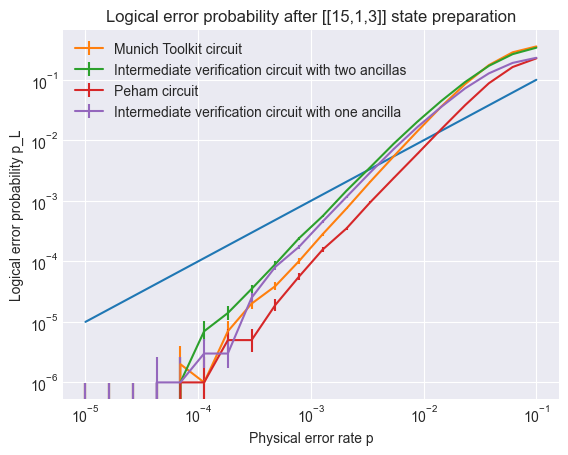

In [115]:
# The following code is for plotting the logical error probability against the physical error rate.
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"p_log_tetr_stateprep_comparison_{timestamp}.png"

plt.plot(p_values, p_values)
plot_multiple_errorbars(
    p_values,
    [norm_p_log, norm_p_log_2, norm_p_log_peham, norm_p_log_one_ancilla],
    [errorbars_err, errorbars_err_2, errorbars_err_peham, errorbars_err_one_ancilla],
    ["Munich Toolkit circuit", "Intermediate verification circuit with two ancillas", 
     "Peham circuit", "Intermediate verification circuit with one ancilla"],
    xlabel="Physical error rate p",
    ylabel="Logical error probability p_L",
    title="Logical error probability after [[15,1,3]] state preparation",
    filename=filename
)


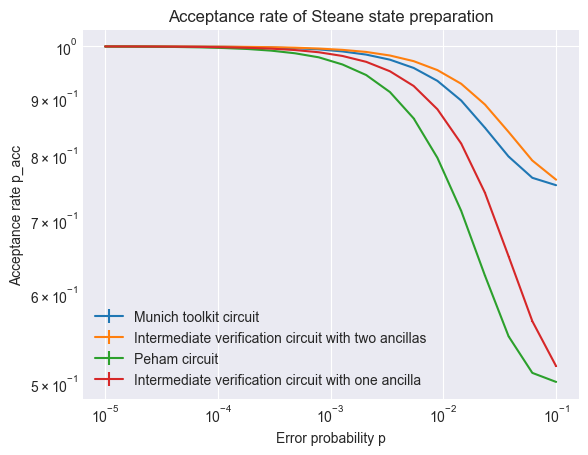

In [116]:
# The following code is for plotting the acceptance rate against the physical error rate.
filename_acc = f"p_acc_tetr_rus_{timestamp}.png"

plot_multiple_errorbars(
    p_values,
    [norm_p_acc, norm_p_acc_2, norm_p_acc_peham, norm_p_acc_one_ancilla],
    [errorbars_acc, errorbars_acc_2, errorbars_acc_peham, errorbars_acc_one_ancilla],
    ["Munich toolkit circuit", "Intermediate verification circuit with two ancillas", 
     "Peham circuit", "Intermediate verification circuit with one ancilla"],
    xlabel="Error probability p",
    ylabel="Acceptance rate p_acc",
    title="Acceptance rate of Steane state preparation",
    filename=filename_acc,
    legend_loc="lower left"
)

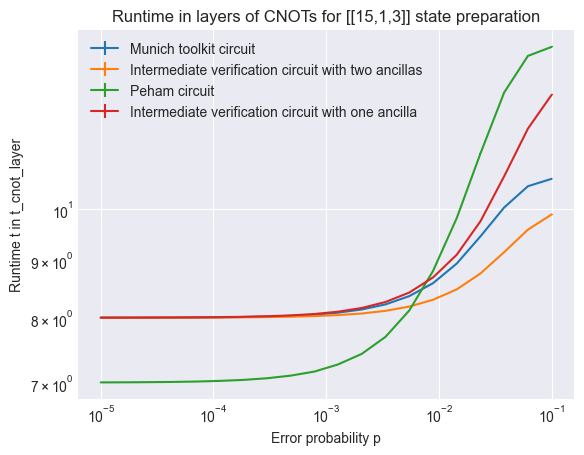

In [112]:
# The following code is for plotting the runtime in layers of CNOTs against the physical error rate.
filename_runtime = f"runtime_tetr_rus_{timestamp}.png"

plot_multiple_errorbars(
    p_values,
    [time_circuit, time_circuit_2, time_circuit_peham, time_circuit_one_ancilla],
    [errorbars_time, errorbars_time_2, errorbars_time_peham, errorbars_time_one_ancilla],
    ["Munich toolkit circuit", "Intermediate verification circuit with two ancillas", 
     "Peham circuit", "Intermediate verification circuit with one ancilla"],
    xlabel="Error probability p",
    ylabel="Runtime t in t_cnot_layer",
    title="Runtime in layers of CNOTs for [[15,1,3]] state preparation",
    filename=filename_runtime
)